In [4]:
import pickle as pk
from minedatabase.pickaxe import Pickaxe
# import seaborn as sns
import pandas as pd
from copy import deepcopy, copy

# Uncomment only if using
# from minedatabase.filters.feasibility import ReactionFeasibilityFilter, _get_feasibility
# from minedatabase.thermodynamics import Thermodynamics


In [29]:
with open("thermo_dict.pk", "rb") as f:
    d = pk.load(f)

v = list(d.values())[2]
value = v.value.magnitude
error = v.error.magnitude

df = pd.DataFrame(data=[(key, val.value.magnitude, val.error.magnitude) for key, val in d.items()], columns=["_id", "value", "error"])
df.to_csv("thermo_dataframe_physiological.csv", index=False)

In [26]:
thermo = Thermodynamics()
thermo.load_thermo_from_postgres()

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading ecoli_metab_100t300r200.pk pickled data.
Loaded 21336 compounds
Loaded 38175 reactions
Loaded 50 operators
Took 0.2244400978088379


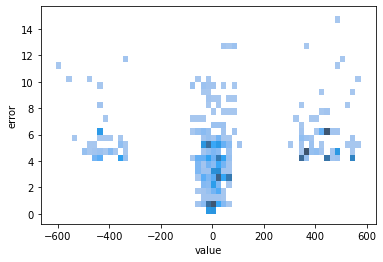

In [21]:
# # Load in thermodynamics
dg_df = pd.read_csv("thermo_dataframe_physiological.csv")
dg_df = dg_df[dg_df.error <= 30]

sns.histplot(dg_df, x="value", y="error")

# Load in pickaxe 
pk = Pickaxe()
pk.load_pickled_pickaxe("ecoli_metab_100t300r200.pk")

In [22]:
highdg_df = dg_df[dg_df.value > 550].reset_index()
highdg_df

,index,Unnamed: 0,_id,value,error
0,79,79,Ra6a9dba9ff7a176496c2bd0bc229f2f78d3765c591742...,550.115246,4.359322
1,309,309,R38bce8818e66468067a42a50a66e3ede4e2c870050701...,550.900809,5.670090
2,446,446,R010229c7646ed2efb371496ac071e37fd179a4d9a3712...,550.115169,4.359322
3,553,553,R2cb0b8f38374a3f103abab04f671c668cb0a9a3e04371...,550.115246,4.359322
4,701,701,Rc1e2f13b01360e5d281664d52f904b0b43d97fae042dc...,550.094594,4.359322
5,822,822,R18ab731317718c594ba99d45a1709139f14a91dec2ee0...,554.131480,4.528423
6,1058,1058,Rcc1a2508aff640dff9737a0218a70c912b7cb4a1b4f71...,550.115133,4.359322
7,1072,1072,R0343bb5aa16e007527663219700c92a353c2110b0aaa8...,575.276622,10.181131
8,1111,1111,R3026152d6847fa6b494058f430ca21664c9a544ac43ff...,566.860656,5.357577
9,1152,1152,Rb8383815dd92dfd672e92e89988a07c0befd141b6555c...,550.114926,4.359322


In [23]:
pk.reactions[highdg_df["_id"][0]]

{'_id': 'Ra6a9dba9ff7a176496c2bd0bc229f2f78d3765c59174231445e56994ca0be586',
 'Reactants': [(2, 'C6e540dcff6053a94ee5729f652c14c32fe1a643b'),
  (1, 'Xad024c97bc6d1c83baf5d8902af02c3a3db5358e')],
 'Products': [(1, 'C1c6323c6e40825ab59122e183b158e80fea43e7d'),
  (1, 'C306bbfe976e04926a1fef270ce0bc924ce4a569c'),
  (1, 'X8dc023d8052d83fb6feadf8541387e57c199cad0')],
 'Operators': ['rule0044'],
 'SMILES_rxn': '(2) O=C(O)C=C(CC(=O)O)C(=O)O + (1) O=C=O => (1) O=CC=C(CC(=O)O)C(=O)O + (1) O=C(O)C=C(CC(=O)C(=O)O)C(=O)O + (1) O=O'}

In [30]:
thermo.physiological_dg_prime_from_rid(highdg_df["_id"][0], pk)
rxn = thermo.get_eQ_reaction_from_rid(highdg_df["_id"][0], pk)

In [35]:
[rxn.get_abundance(cpd) for cpd in rxn.sparse_with_phases.keys()]

[1 <Unit('molar')>,
 1 <Unit('molar')>,
 1 <Unit('molar')>,
 1 <Unit('molar')>,
 1 <Unit('molar')>]

In [ ]:
from equilibrator_api import Q_
from equilibrator_api.component_contribution import ComponentContribution
cc = ComponentContribution()

# cis-Aconitate -> Itaconate + CO2
https://equilibrator.weizmann.ac.il/search?query=cis-Aconitate+%3C%3D%3E+Itaconate+%2B+CO2&x=0&y=0

In [138]:
smiA_stereo = "C(C(=CC(=O)O)C(=O)O)C(=O)O"
smiB = "O=C=O"
smiC = "C=C(CC(=O)O)C(=O)O"

cpdA = thermo.lc.get_compounds(smiA)
cpdB = thermo.lc.get_compounds(smiB)
cpdC = thermo.lc.get_compounds(smiC)

reaction_string = "1 A => 1 B + 1 C"

eq_compound_dict = {
    "A": cpdA,
    "B": cpdB,
    "C": cpdC
}

eq_reaction = Reaction.parse_formula(eq_compound_dict.get, reaction_string)

thermo.CC.p_h = Q_("7.5")
thermo.CC.p_mg = Q_("3.0")
thermo.CC.ionic_strength = Q_(".25M")

print(thermo.CC.physiological_dg_prime(eq_reaction))

cpds = list(eq_reaction.sparse.keys())
[(cc.standard_dg_formation(cpd)[0], cpd.smiles) for cpd in cpds]


(-25.9 +/- 3.3) kilojoule / mole


[(-920.5463408139223, '[O-]C(=O)CC(=CC([O-])=O)C([O-])=O'),
 (-386.0000000000019, 'O=C=O'),
 (-590.9420045695858, '[O-]C(=O)CC(=C)C([O-])=O')]

# My Aconitate

In [135]:
pk.reactions[highdg_df["_id"][0]]["SMILES_rxn"]

'(2) O=C(O)C=C(CC(=O)O)C(=O)O + (1) O=C=O => (1) O=CC=C(CC(=O)O)C(=O)O + (1) O=C(O)C=C(CC(=O)C(=O)O)C(=O)O + (1) O=O'

In [137]:
smiA = "O=C(O)C=C(CC(=O)O)C(=O)O"
smiB = "O=C=O"
smiC = "O=CC=C(CC(=O)O)C(=O)O"
smiD = "O=C(O)C=C(CC(=O)C(=O)O)C(=O)O"
smiE = "O=O"

cpdA = thermo.lc.get_compounds(smiA)
cpdB = thermo.lc.get_compounds(smiB)
cpdC = thermo.lc.get_compounds(smiC)
cpdD = thermo.lc.get_compounds(smiD)
cpdE = thermo.lc.get_compounds(smiE)

reaction_string = "2 A + 1 B => 1 C + 1 D + 1 E"

eq_compound_dict = {
    "A": cpdA,
    "B": cpdB,
    "C": cpdC,
    "D": cpdD,
    "E": cpdE
}

eq_reaction = Reaction.parse_formula(eq_compound_dict.get, reaction_string)

thermo.CC.p_h = Q_("7.5")
thermo.CC.p_mg = Q_("3.0")
thermo.CC.ionic_strength = Q_(".25M")

print(thermo.CC.physiological_dg_prime(eq_reaction))

cpds = list(eq_reaction.sparse.keys())
[(cc.standard_dg_formation(cpd)[0], cpd.smiles) for cpd in cpds]


(550 +/- 4) kilojoule / mole


[(-920.5463408139223, '[O-]C(=O)CC(=CC([O-])=O)C([O-])=O'),
 (-386.0000000000019, 'O=C=O'),
 (-703.7759334310863, '[O-]C(=O)CC(=CC=O)C([O-])=O'),
 (-1037.2469110312636, '[O-]C(=O)C=C(CC(=O)C([O-])=O)C([O-])=O'),
 (16.399999999865035, 'O=O')]

True

In [110]:
rxn = thermo.get_eQ_reaction_from_rid(highdg_df["_id"][0], pk)
list(rxn.sparse_with_phases.keys())[1].phase = "gas"
list(rxn.sparse_with_phases.keys())[4].phase = "gas"

co2 = thermo.lc.get_compounds("O=C=O")
o2 = thermo.lc.get_compounds("O=O")

rxn.set_abundance(o2, Q_("1 atm"))
rxn.set_abundance(co2, Q_("1 atm"))

cc.dg_prime(rxn)

<Measurement(542.0752457105235, 1.3460894780459531, kilojoule / mole)>

In [115]:
cpds = list(rxn.sparse.keys())
[(cc.standard_dg_formation(cpd)[0], cpd.smiles) for cpd in cpds]

[(-920.5463408139223, '[O-]C(=O)CC(=CC([O-])=O)C([O-])=O'),
 (-386.0000000000019, 'O=C=O'),
 (-703.7759334310863, '[O-]C(=O)CC(=CC=O)C([O-])=O'),
 (-1037.2469110312636, '[O-]C(=O)C=C(CC(=O)C([O-])=O)C([O-])=O'),
 (16.399999999865035, 'O=O')]

In [123]:
pk.reactions[highdg_df["_id"][0]]

{'_id': 'Ra6a9dba9ff7a176496c2bd0bc229f2f78d3765c59174231445e56994ca0be586',
 'Reactants': [(2, 'C6e540dcff6053a94ee5729f652c14c32fe1a643b'),
  (1, 'Xad024c97bc6d1c83baf5d8902af02c3a3db5358e')],
 'Products': [(1, 'C1c6323c6e40825ab59122e183b158e80fea43e7d'),
  (1, 'C306bbfe976e04926a1fef270ce0bc924ce4a569c'),
  (1, 'X8dc023d8052d83fb6feadf8541387e57c199cad0')],
 'Operators': ['rule0044'],
 'SMILES_rxn': '(2) O=C(O)C=C(CC(=O)O)C(=O)O + (1) O=C=O => (1) O=CC=C(CC(=O)O)C(=O)O + (1) O=C(O)C=C(CC(=O)C(=O)O)C(=O)O + (1) O=O'}

In [108]:
smiA = "CC(=O)C(O)(C)C(=O)O"
smiB = "O=C=O"
smiC = "CC(=O)C(=O)O"

cpdA = thermo.lc.get_compounds(smiA)
cpdB = thermo.lc.get_compounds(smiB)
cpdC = thermo.lc.get_compounds(smiC)

reaction_string = "1 A + 1 B => 2 C"

eq_compound_dict = {
    "A": cpdA,
    "B": cpdB,
    "C": cpdC
}

eq_reaction = Reaction.parse_formula(eq_compound_dict.get, reaction_string)

thermo.CC.physiological_dg_prime(eq_reaction)

cpds = list(eq_reaction.sparse.keys())
[(cc.standard_dg_formation(cpd)[0], cpd.smiles) for cpd in cpds]


[(-621.6243783367249, 'CC(=O)C(C)(O)C([O-])=O'),
 (-386.0000000000019, 'O=C=O'),
 (-467.91458028218807, 'CC(=O)C([O-])=O')]

In [131]:
# R02243

smiA = "C(/C(=C/C(=O)O)/C(=O)O)C(=O)O"
smiB = "O=C=O"
smiC = "C=C(CC(=O)O)C(=O)O"

cpdA = thermo.lc.get_compounds(smiA)
cpdB = thermo.lc.get_compounds(smiB)
cpdC = thermo.lc.get_compounds(smiC)

reaction_string = "1 A + 1 B => 1 C"

eq_compound_dict = {
    "A": cpdA,
    "B": cpdB,
    "C": cpdC
}

eq_reaction = Reaction.parse_formula(eq_compound_dict.get, reaction_string)

thermo.CC.p_h = Q_("7.5")
thermo.CC.p_mg = Q_("3.0")
thermo.CC.ionic_strength = Q_(".25M")

print(thermo.CC.physiological_dg_prime(eq_reaction))

cpds = list(eq_reaction.sparse.keys())
[(cc.standard_dg_formation(cpd)[0], cpd.smiles) for cpd in cpds]


(776 +/- 4) kilojoule / mole


[(-915.7680914427044, '[O-]C(=O)C\\C(=C\\C([O-])=O)C([O-])=O'),
 (-386.0000000000019, 'O=C=O'),
 (-590.9420045695858, '[O-]C(=O)CC(=C)C([O-])=O')]

In [109]:
smiA = "CC(=O)C(=O)[O-]"
smiB = "[O-]P(=O)([O-])[O-]"
smiC = "O=O"
smiD = "CC(=O)OP(=O)(O)O"
smiE = "OO"
smiF = "O=C=O"

cpdA = thermo.lc.get_compounds(smiA)
cpdB = thermo.lc.get_compounds(smiB)
cpdC = thermo.lc.get_compounds(smiC)
cpdD = thermo.lc.get_compounds(smiD)
cpdE = thermo.lc.get_compounds(smiE)
cpdF = thermo.lc.get_compounds(smiF)


reaction_string = "1 A + 1 B + 1 C => 1 D + 1 E + 1 F"

eq_compound_dict = {
    "A": cpdA,
    "B": cpdB,
    "C": cpdC,
    "D": cpdD,
    "E": cpdE,
    "F": cpdF
}

eq_reaction = Reaction.parse_formula(eq_compound_dict.get, reaction_string)

thermo.CC.physiological_dg_prime(eq_reaction)

cpds = list(eq_reaction.sparse.keys())
[(cc.standard_dg_formation(cpd)[0], cpd.smiles) for cpd in cpds]


[(-467.91458028218807, 'CC(=O)C([O-])=O'),
 (-1095.2054811974629, 'OP([O-])([O-])=O'),
 (16.399999999865035, 'O=O'),
 (-1226.7914128825068, 'CC(=O)OP([O-])([O-])=O'),
 (-133.98848078973268, 'OO'),
 (-386.0000000000019, 'O=C=O')]

In [ ]:
reactants = reaction_info["Reactants"]
        products = reaction_info["Products"]

        lhs = " + ".join(f"{r[0]} {r[1]}" for r in reactants)
        rhs = " + ".join(f"{p[0]} {p[1]}" for p in products)
        reaction_string = " => ".join([lhs, rhs])

In [91]:
reaction_info = pk.reactions[highdg_df["_id"][0]]

reactants = reaction_info["Reactants"]
products = reaction_info["Products"]


lhs = " + ".join(f"{r[0]} {r[1]}" for r in reactants)
rhs = " + ".join(f"{p[0]} {p[1]}" for p in products)
reaction_string = " => ".join([lhs, rhs])

compounds = set([r[1] for r in reactants])
compounds.update(tuple(p[1] for p in products))

eQ_compound_dict = {
    c_id: thermo.get_eQ_compound_from_cid(c_id, pk)
    for c_id in compounds
}

eQ_compound_dict

if "X73bc8ef21db580aefe4dbc0af17d4013961d9d17" not in compounds:
    eQ_compound_dict["water"] = thermo.lc.get_compounds("O")

eq_reaction = Reaction.parse_formula(eQ_compound_dict.get, reaction_string)

In [99]:
list(eQ_compound_dict.values())[0].identifiers

[CompoundIdentifier(registry=Registry(namespace=synonyms), accession=696236)]

In [94]:
reaction_string

'2 C6e540dcff6053a94ee5729f652c14c32fe1a643b + 1 Xad024c97bc6d1c83baf5d8902af02c3a3db5358e => 1 C1c6323c6e40825ab59122e183b158e80fea43e7d + 1 C306bbfe976e04926a1fef270ce0bc924ce4a569c + 1 X8dc023d8052d83fb6feadf8541387e57c199cad0'

In [90]:
from equilibrator_api import Reaction